# Импорты

In [1]:
%%time
# здесь будем ставить все, чего нам не хватает
# !pip install missingno -q
# !pip install optuna -q
# !pip install tqdm -q
# !pip install seaborn -q
# !pip install torch -q
# !pip install scikit-learn -q
# !pip install statsmodels -q

CPU times: total: 0 ns
Wall time: 3.58 μs


In [2]:
import pandas as pd
import psycopg2
import logging
from sqlalchemy import create_engine
import sqlalchemy
import time
import socket
import sys

# === Функции проекта ===
from func import (
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
    plot_results,
    plot_categorical_columns,
    plot_scatter_with_numerical
)

from creds import db_config

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# Подключение к базе и получение данных

In [3]:
# Импортируем конфигурацию из отдельного файла
try:
    logger.info("Конфигурация загружена из creds.py")
except ImportError:
    logger.info("Файл creds.py не найден")
    db_config = {
        'user': input("Введите имя пользователя: "),
        'pwd': input("Введите пароль: "),
        'host': input("Введите хост: "),
        'port': input("Введите порт: "),
        'db': input("Введите название БД: ")
    }

2025-11-25 16:30:24 [INFO] __main__: Конфигурация загружена из creds.py


In [4]:
def check_host_availability():
    """Проверка доступности хоста"""
    try:
        socket.create_connection((db_config['host'], db_config['port']), timeout=10)
        logger.info("Хост доступен")
        return True
    except socket.error as e:
        logger.info(f"Хост недоступен: {e}")
        sys.exit("ОСТАНОВКА: Не удалось подключиться к базе данных. Дальнейшее выполнение невозможно.")

check_host_availability()

2025-11-25 16:30:24 [INFO] __main__: Хост доступен


True

Хост доступен, можем подключаться и загружать данные.   

In [ ]:
# если с хостом все ок, то подключаемся и забираем данные
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

def load_data_safe(engine, table_name_or_query, use_chunks=True, chunksize=300000):
    """Загружает данные - либо таблицу целиком, либо по SQL-запросу"""
    try:
        # Определяем тип загрузки
        if isinstance(table_name_or_query, str) and table_name_or_query.strip().upper().startswith('SELECT'):
            # Это SQL-запрос - загружаем напрямую
            logger.info(f"Загружаем данные по SQL-запросу...")
            result = pd.read_sql(table_name_or_query, engine)
            logger.info(f"Загружено: {result.shape[0]} строк, {result.shape[1]} столбцов")
            return result
        else:
            # Это имя таблицы
            table_name = table_name_or_query
            if use_chunks:
                # Загружаем по частям
                logger.info(f"Загружаем таблицу {table_name} по частям...")
                count_query = f"SELECT COUNT(*) FROM {table_name}"
                total_rows = pd.read_sql(count_query, engine).iloc[0,0]
                logger.info(f"Всего строк в {table_name}: {total_rows}")
                
                chunks = []
                for offset in range(0, total_rows, chunksize):
                    query = f"SELECT * FROM {table_name} LIMIT {chunksize} OFFSET {offset}"
                    chunk = pd.read_sql(query, engine)
                    chunks.append(chunk)
                    logger.info(f"Загружено {len(chunk)} строк (прогресс: {min(offset + chunksize, total_rows)}/{total_rows})")
                
                result = pd.concat(chunks, ignore_index=True)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
            else:
                # Загружаем целиком
                logger.info(f"Загружаем таблицу {table_name}...")
                result = pd.read_sql(f"SELECT * FROM {table_name}", engine)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
        
    except Exception as e:
        logger.error(f"Ошибка при загрузке: {e}")
        return None

def load_all_tables_safe(engine, tables_config):
    """Безопасная загрузка всех таблиц/запросов"""
    dataframes = {}
    
    for table_name, table_ref in tables_config.items():
        dataframes[table_name] = load_data_safe(engine, table_ref)
    
    return dataframes

In [6]:
logger.info("=== ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===")
full_tables_config = {
    'collisions': 'collisions',
    'parties': 'parties', 
    'vehicles': 'vehicles'
}

df_dict_full = load_all_tables_safe(engine, full_tables_config)

# Проверяем что все таблицы загружены
successful_tables = {k: v for k, v in df_dict_full.items() if v is not None}

if len(successful_tables) == len(full_tables_config):
    collisions_default = df_dict_full['collisions']
    parties_default = df_dict_full['parties']
    vehicles_default = df_dict_full['vehicles']
    logger.info("Все полные данные успешно загружены")
else:
    logger.warning(f"Загружены только таблицы: {list(successful_tables.keys())}")

2025-11-25 16:30:24 [INFO] __main__: === ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===
2025-11-25 16:30:24 [INFO] __main__: Загружаем таблицу collisions по частям...
2025-11-25 16:30:25 [INFO] __main__: Всего строк в collisions: 1400000
2025-11-25 16:30:33 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/1400000)
2025-11-25 16:30:42 [INFO] __main__: Загружено 300000 строк (прогресс: 600000/1400000)
2025-11-25 16:30:51 [INFO] __main__: Загружено 300000 строк (прогресс: 900000/1400000)
2025-11-25 16:31:00 [INFO] __main__: Загружено 300000 строк (прогресс: 1200000/1400000)
2025-11-25 16:31:05 [INFO] __main__: Загружено 200000 строк (прогресс: 1400000/1400000)
2025-11-25 16:31:06 [INFO] __main__: collisions: 1400000 строк, 20 столбцов
2025-11-25 16:31:06 [INFO] __main__: Загружаем таблицу parties по частям...
2025-11-25 16:31:06 [INFO] __main__: Всего строк в parties: 2752408
2025-11-25 16:31:10 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/2752408)
2025-11-25 16:31:13 [INFO] __main__: З

In [7]:
collisions_default.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [8]:
parties_default.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [9]:
vehicles_default.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


Да, много данных. Посмотрим, как это число изменится если мы сразу получим только то, что нам нужно

В тз у нас есть ограничения на выборку - учтем их сразу в запросах, чтобы не тащить все данные.  
- Для модели выбрать тип виновника — только машина (car).  
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
- Для моделирования ограничиться данными за 2012 год — они самые свежие.  

Также отберем только нужные признаки, который будут полезны для модели.

# Отбор признаков для модели предсказания виновности в ДТП

## Признаки для модели

Из таблицы `collisions`

| Признак | Обоснование |
|---------|-------------|
| `WEATHER_1` | Погодные условия напрямую влияют на видимость и управляемость транспортным средством |
| `ROAD_SURFACE` | Состояние дорожного покрытия значительно воздействует на риск возникновения ДТП |
| `LIGHTING` | Уровень освещённости влияет на видимость и скорость реакции водителя |
| `INTERSECTION` | Перекрестки являются зонами повышенной аварийности и сложности манёвров |
| `LOCATION_TYPE` | Тип дороги определяет характер движения и потенциальные риски |
| `PCF_VIOLATION_CATEGORY` | Ключевой признак - категории нарушений ПДД напрямую коррелируют с виновностью |
| `TYPE_OF_COLLISION` | Тип столкновения может указывать на действия виновника аварии |
| `ROAD_CONDITION_1` | Дополнительные дорожные условия создают дополнительные факторы риска |

Из таблицы `parties`

| Признак | Обоснование |
|---------|-------------|
| `PARTY_DRUG_PHYSICAL` | Важный признак - физическое состояние водителя напрямую влияет на виновность |
| `PARTY_SOBRIETY` | Критический признак - состояние трезвости является ключевым фактором определения виновника |
| `CELLPHONE_IN_USE` | Использование телефона за рулём приводит к отвлечению внимания и нарушениям |

Из таблицы `vehicles`

| Признак | Обоснование |
|---------|-------------|
| `VEHICLE_AGE` | Обязателен по ТЗ - возраст автомобиля может влиять на техническую исправность и безопасность |
| `VEHICLE_TYPE` | Тип кузова может влиять на управляемость и поведение транспортного средства |

---

## Признаки для исключения из модели

Технические и идентификационные признаки
- `CASE_ID`, `ID` - уникальные идентификаторы, не несут прогнозной способности
- `PARTY_NUMBER` - технический номер участника в рамках ДТП

Географические признаки
- `COUNTY_CITY_LOCATION`, `COUNTY_LOCATION` - без детальных карт и анализа дорожной инфраструктуры сложно интерпретировать
- `DIRECTION` - направление движения само по себе не является информативным признаком

Временные признаки
- `COLLISION_DATE`, `COLLISION_TIME` - рекомендуется вынести в отдельный анализ сезонности и времени суток
- PS: по тз есть задача оценить по месяцам, поэтому COLLISION_DATE все таки оставим  

Избыточные и производные признаки
- `PRIMARY_COLLISION_FACTOR` - дублирует информацию из `PCF_VIOLATION_CATEGORY`, но в более обобщённой форме
- `PARTY_COUNT` - количество участников ДТП слабо коррелирует с виновностью конкретного водителя
- `DISTANCE` - расстояние от главной дороги без дополнительного контекста не информативно
- `MOTOR_VEHICLE_INVOLVED_WITH` - тип второго участника менее важен, чем действия самого виновника
- `INSURANCE_PREMIUM` - страховая премия является скорее следствием, чем причиной ДТП

In [12]:
logger.info("=== ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===")

# оптимизированные запросы с учетом отбора признаков
collisions_query = """
SELECT 
    case_id,
    weather_1,
    road_surface,
    lighting,
    intersection,
    location_type,
    pcf_violation_category,
    type_of_collision,
    road_condition_1,
    collision_date::date as collision_date
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date) = 2012
    AND collision_damage <> 'scratch'
"""

parties_query = """
SELECT 
    case_id,
    party_number,
    at_fault,
    party_drug_physical,
    party_sobriety,
    cellphone_in_use
FROM parties 
WHERE party_type = 'car'
"""

vehicles_query = """
SELECT 
    case_id,
    party_number,
    vehicle_type,
    vehicle_age,
    vehicle_transmission
FROM vehicles
WHERE case_id IN (
    SELECT DISTINCT case_id 
    FROM parties 
    WHERE party_type = 'car'
)
"""

filtered_tables_config = {
    'collisions': collisions_query,
    'parties': parties_query, 
    'vehicles': vehicles_query
}

2025-11-25 16:33:37 [INFO] __main__: === ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===


In [14]:
# Загружаем отфильтрованные таблицы
df_dict_filtered = load_all_tables_safe(engine, filtered_tables_config)

# Проверяем успешность загрузки и создаем переменные
successful_tables = {k: v for k, v in df_dict_filtered.items() if v is not None}

if len(successful_tables) == len(filtered_tables_config):
    collisions = df_dict_filtered['collisions']
    parties = df_dict_filtered['parties']
    vehicles = df_dict_filtered['vehicles']
    
    logger.info("Все отфильтрованные данные успешно загружены и готовы к анализу.")
    
    # Выводим информацию о загруженных данных
    logger.info("Статистика отфильтрованных таблиц:")
    logger.info(f"collisions: {collisions.shape[0]:,} строк, {collisions.shape[1]} столбцов")
    logger.info(f"parties: {parties.shape[0]:,} строк, {parties.shape[1]} столбцов") 
    logger.info(f"vehicles: {vehicles.shape[0]:,} строк, {vehicles.shape[1]} столбцов")
    
else:
    logger.warning(f"Загружены не все таблицы. Успешно: {list(successful_tables.keys())}")
    
    # Создаем переменные только для успешно загруженных таблиц
    if 'collisions' in successful_tables:
        collisions = df_dict_filtered['collisions']
    if 'parties' in successful_tables:
        parties = df_dict_filtered['parties']
    if 'vehicles' in successful_tables:
        vehicles = df_dict_filtered['vehicles']

2025-11-25 16:34:26 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-25 16:34:28 [INFO] __main__: ✅ Загружено: 115666 строк, 10 столбцов
2025-11-25 16:34:28 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-25 16:34:48 [INFO] __main__: ✅ Загружено: 2469314 строк, 6 столбцов
2025-11-25 16:34:48 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-25 16:34:58 [INFO] __main__: ✅ Загружено: 1013759 строк, 5 столбцов
2025-11-25 16:34:58 [INFO] __main__: Все отфильтрованные данные успешно загружены и готовы к анализу.
2025-11-25 16:34:58 [INFO] __main__: Статистика отфильтрованных таблиц:
2025-11-25 16:34:58 [INFO] __main__: collisions: 115,666 строк, 10 столбцов
2025-11-25 16:34:58 [INFO] __main__: parties: 2,469,314 строк, 6 столбцов
2025-11-25 16:34:58 [INFO] __main__: vehicles: 1,013,759 строк, 5 столбцов


In [21]:
def create_simple_comparison_table(default_data, cleaned_data, table_names):
    """
    Создает простую сравнительную таблицу по строкам и столбцам
    """
    comparison_data = []
    
    for table_name in table_names:
        default_df = default_data[table_name]
        cleaned_df = cleaned_data[table_name]
        
        comparison_data.append({
            'Таблица': table_name,
            'Было строк': default_df.shape[0],
            'Стало строк': cleaned_df.shape[0],
            'Было колонок': default_df.shape[1],
            'Стало колонок': cleaned_df.shape[1]
        })
    
    return pd.DataFrame(comparison_data)

# Используем новые переменные из предыдущего кода
table_names = ['collisions', 'parties', 'vehicles']

comparison_df = create_simple_comparison_table(
    {
        'collisions': collisions_default if 'collisions_default' in locals() else df_dict_full['collisions'],
        'parties': parties_default if 'parties_default' in locals() else df_dict_full['parties'], 
        'vehicles': vehicles_default if 'vehicles_default' in locals() else df_dict_full['vehicles']
    },
    {
        'collisions': collisions if 'collisions' in locals() else df_dict_filtered['collisions'],
        'parties': parties if 'parties' in locals() else df_dict_filtered['parties'],
        'vehicles': vehicles if 'vehicles' in locals() else df_dict_filtered['vehicles']
    },
    table_names
)

# Форматируем вывод
comparison_df_formatted = comparison_df.copy()
comparison_df_formatted['Было строк'] = comparison_df_formatted['Было строк'].apply(lambda x: f"{x:,}")
comparison_df_formatted['Стало строк'] = comparison_df_formatted['Стало строк'].apply(lambda x: f"{x:,}")

logger.info("Сравнительная таблица оптимизации данных")
logger.info("=" * 60)
display(comparison_df_formatted)

# Расчет процентных изменений
logger.info("Процентные изменения:")
logger.info("=" * 40)
for _, row in comparison_df.iterrows():
    rows_change = ((row['Стало строк'] - row['Было строк']) / row['Было строк']) * 100
    cols_change = ((row['Стало колонок'] - row['Было колонок']) / row['Было колонок']) * 100
    
    logger.info(f"{row['Таблица']}: строки {rows_change:+.1f}%, колонки {cols_change:+.1f}%")

# Итоговая статистика
logger.info("Итоговая статистика оптимизации:")
logger.info("=" * 40)
total_rows_before = comparison_df['Было строк'].sum()
total_rows_after = comparison_df['Стало строк'].sum()
total_cols_before = comparison_df['Было колонок'].sum()
total_cols_after = comparison_df['Стало колонок'].sum()

total_rows_change = ((total_rows_after - total_rows_before) / total_rows_before) * 100
total_cols_change = ((total_cols_after - total_cols_before) / total_cols_before) * 100

logger.info(f"Всего строк: {total_rows_before:,} -> {total_rows_after:,} ({total_rows_change:+.1f}%)")
logger.info(f"Всего колонок: {total_cols_before} -> {total_cols_after} ({total_cols_change:+.1f}%)")

2025-11-25 16:35:54 [INFO] __main__: Сравнительная таблица оптимизации данных
2025-11-25 16:35:54 [INFO] __main__: ============================================================


,Таблица,Было строк,Стало строк,Было колонок,Стало колонок
0,collisions,"1,400,000","115,666",20,10
1,parties,"2,752,408","2,469,314",9,6
2,vehicles,"1,021,234","1,013,759",6,5


2025-11-25 16:35:54 [INFO] __main__: Процентные изменения:
2025-11-25 16:35:54 [INFO] __main__: ========================================
2025-11-25 16:35:54 [INFO] __main__: collisions: строки -91.7%, колонки -50.0%
2025-11-25 16:35:54 [INFO] __main__: parties: строки -10.3%, колонки -33.3%
2025-11-25 16:35:54 [INFO] __main__: vehicles: строки -0.7%, колонки -16.7%
2025-11-25 16:35:54 [INFO] __main__: Итоговая статистика оптимизации:
2025-11-25 16:35:54 [INFO] __main__: ========================================
2025-11-25 16:35:54 [INFO] __main__: Всего строк: 5,173,642 -> 3,598,739 (-30.4%)
2025-11-25 16:35:54 [INFO] __main__: Всего колонок: 35 -> 21 (-40.0%)


## Оценка collisions

### collisions - общие данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115666 entries, 0 to 115665
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   case_id                 115666 non-null  object 
 1   weather_1               115249 non-null  object 
 2   road_surface            114856 non-null  object 
 3   lighting                115164 non-null  object 
 4   intersection            114949 non-null  float64
 5   location_type           46244 non-null   object 
 6   pcf_violation_category  113329 non-null  object 
 7   type_of_collision       114607 non-null  object 
 8   road_condition_1        114944 non-null  object 
 9   collision_date          115666 non-null  object 
dtypes: float64(1), object(9)
memory usage: 8.8+ MB


None

,case_id,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,collision_date
97593,5490681,clear,dry,daylight,1.0,None,dui,head-on,normal,2012-02-10
25546,5496337,clear,dry,daylight,0.0,None,speeding,rear end,normal,2012-01-02
63745,5584962,raining,wet,daylight,0.0,None,improper turning,rear end,normal,2012-04-13
107423,5614828,clear,dry,daylight,0.0,highway,speeding,rear end,normal,2012-04-17
4616,5542719,cloudy,dry,daylight,0.0,None,other than driver (or pedestrian),hit object,normal,2012-02-07


weather_1                   417
road_surface                810
lighting                    502
intersection                717
location_type             69422
pcf_violation_category     2337
type_of_collision          1059
road_condition_1            722
dtype: int64

None

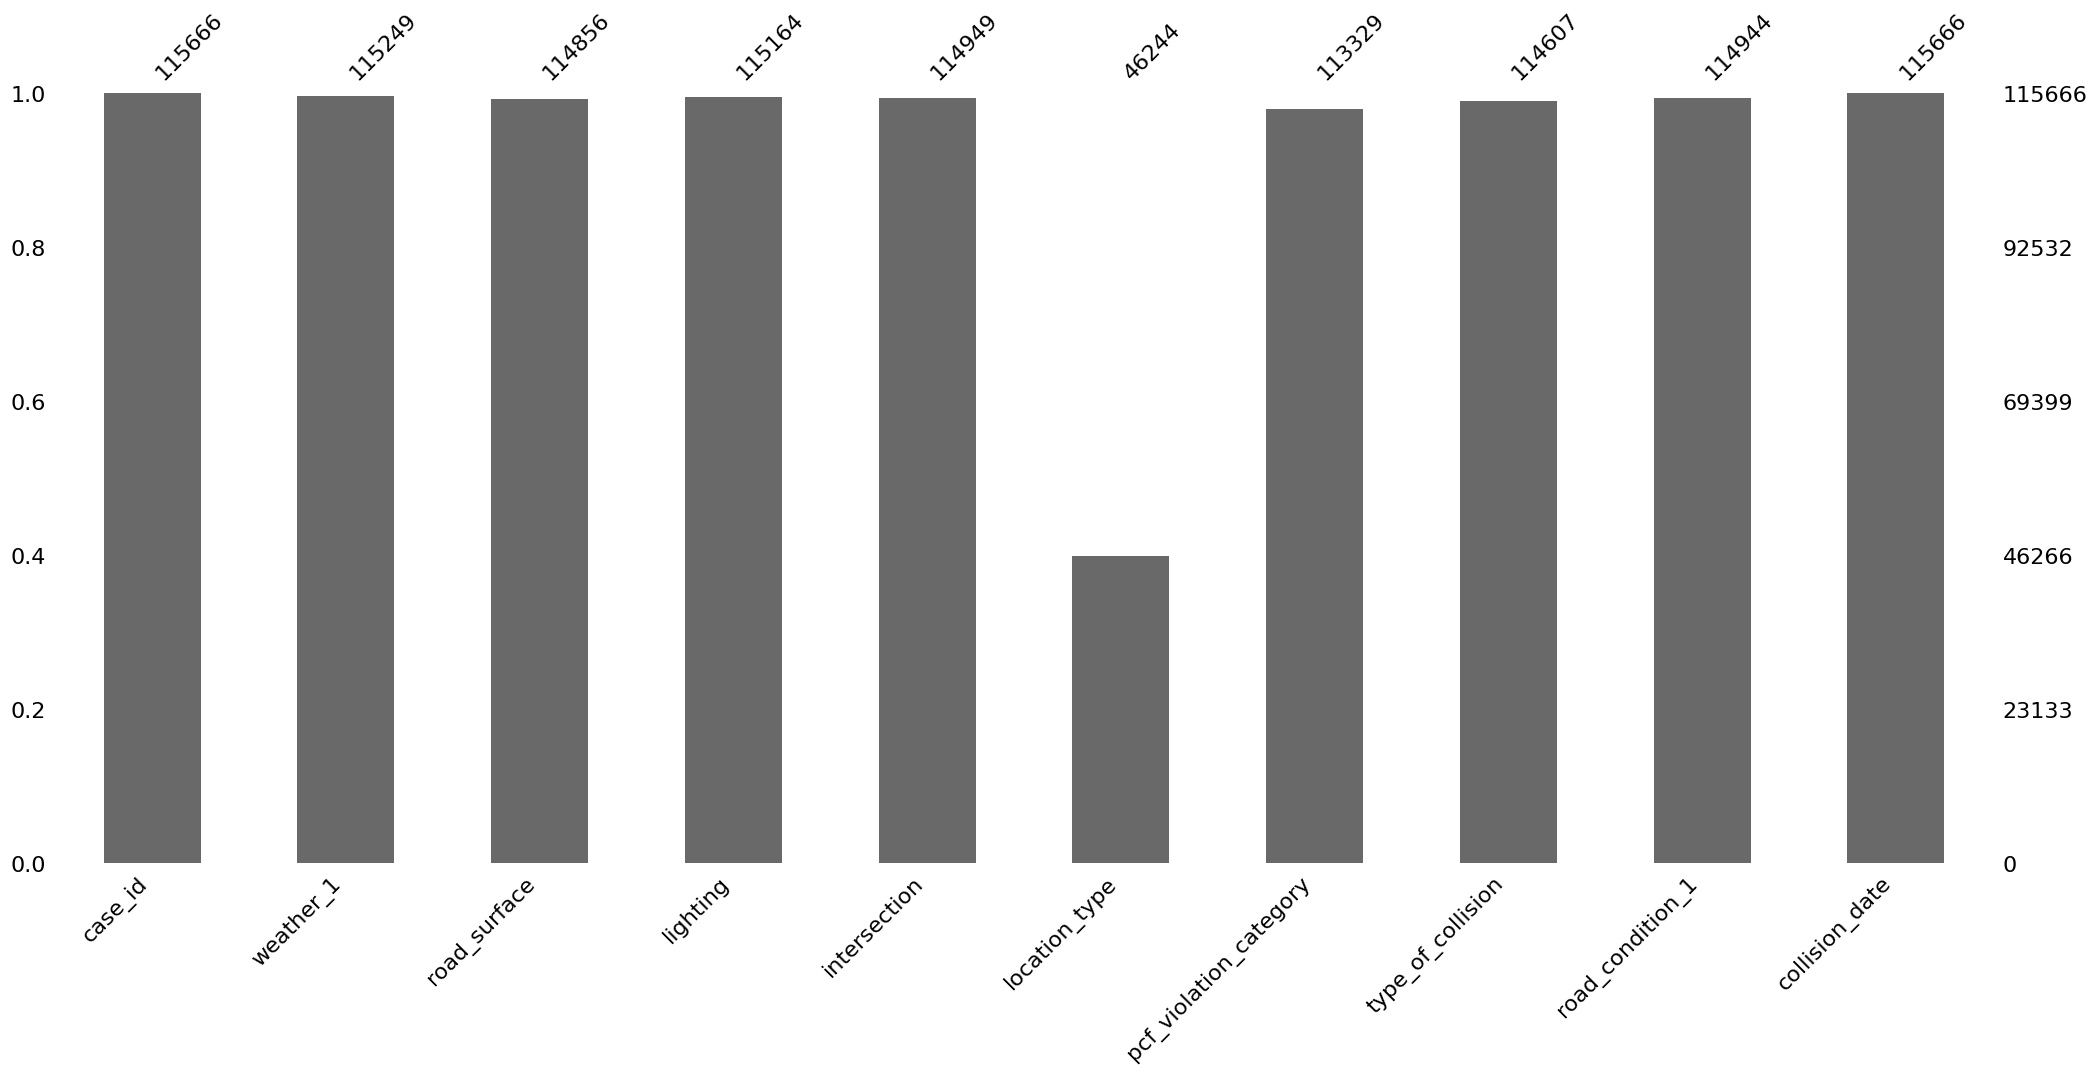

,count,mean,std,min,25%,50%,75%,max
intersection,114949.0,0.188988,0.391501,0.0,0.0,0.0,0.0,1.0


,case_id,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,collision_date
0,5403029,fog,wet,daylight,1.0,None,automobile right of way,broadside,normal,2012-01-03
1,5457328,clear,dry,daylight,0.0,None,None,broadside,normal,2012-01-20
2,5125192,cloudy,dry,daylight,0.0,None,unsafe starting or backing,other,normal,2012-03-16
3,5403121,clear,dry,daylight,0.0,highway,improper turning,hit object,normal,2012-01-05
4,5403122,clear,dry,dusk or dawn,1.0,None,unknown,broadside,normal,2012-01-06
...,...,...,...,...,...,...,...,...,...,...
115661,5667617,clear,dry,daylight,1.0,None,pedestrian right of way,other,normal,2012-06-01
115662,5667740,clear,dry,dark with street lights,1.0,None,pedestrian right of way,other,normal,2012-04-26
115663,5667779,clear,dry,daylight,1.0,None,unsafe starting or backing,other,normal,2012-03-10
115664,5667989,clear,dry,daylight,1.0,None,speeding,other,normal,2012-06-06


In [22]:
check_data(collisions)

Пу-пу-пу....  
1) Первое что бросается в глаза - много пропусков, но сделать мы с ними ничего не можем, поэтому заполним их как unknown  
2) У нас в основном все признаки категориальные, ок, оценим их распределение на таргет  
3) Сгруппируем по месяцам, чтобы понять сезонность ДТП  

### collisions - детальные данные

Детальнее изучим каждый признак

In [23]:
display(collisions['weather_1'].unique())
display(collisions['road_surface'].unique())
display(collisions['lighting'].unique())
display(collisions['location_type'].unique())
display(collisions['pcf_violation_category'].unique())
display(collisions['type_of_collision'].unique())
display(collisions['road_condition_1'].unique())

array(['fog', 'clear', 'cloudy', 'other', 'raining', None, 'wind',
       'snowing'], dtype=object)

array(['wet', 'dry', 'snowy', None, 'slippery'], dtype=object)

array(['daylight', 'dusk or dawn', 'dark with no street lights',
       'dark with street lights',
       'dark with street lights not functioning', None], dtype=object)

array([None, 'highway', 'ramp', 'intersection'], dtype=object)

array(['automobile right of way', None, 'unsafe starting or backing',
       'improper turning', 'unknown', 'traffic signals and signs',
       'wrong side of road', 'speeding', 'dui', 'improper passing',
       'other improper driving', 'other equipment',
       'pedestrian right of way', 'unsafe lane change',
       'hazardous parking', 'other than driver (or pedestrian)',
       'following too closely', 'other hazardous violation',
       'impeding traffic', 'pedestrian violation', 'brakes',
       'fell asleep', 'lights'], dtype=object)

array(['broadside', 'other', 'hit object', 'head-on', 'rear end',
       'sideswipe', 'overturned', None], dtype=object)

array(['normal', 'construction', 'loose material', None, 'obstruction',
       'other', 'holes', 'flooded', 'reduced width'], dtype=object)

Есть конечно же вопросики к определениям типа - скорость и превышение скорости, или другие нарушения и другое неправильное вождение, но будем считать, что здесь все уникально и относится все таки к разным нарушениям.